# Code Along with Autodidact Scientists

### Import Libraries

In [1]:
import os
import shutil 
import random
import zipfile
import tarfile
import numpy as np 
import pandas as pd
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt

### Download the Data

In [2]:
# images of cats and dogs
!wget https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip

# images of birds
!wget https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar

# download the pre-trained models and training histories. 
!wget -q -P /content/model-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/saved_model.pb
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.index
!wget -q -P /content/history-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-balanced/history-balanced.csv

!wget -q -P /content/model-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/saved_model.pb
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.index
!wget -q -P /content/history-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-imbalanced/history-imbalanced.csv

!wget -q -P /content/model-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/saved_model.pb
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.data-00000-of-00001
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.index
!wget -q -P /content/history-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/history-augmented/history-augmented.csv

--2022-11-24 13:16:32--  https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M  29.7MB/s    in 27s     

2022-11-24 13:16:59 (29.4 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]

--2022-11-24 13:16:59--  https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12594790

### Combining the datasets

In [6]:
cats_and_dogs_zip = '/content/kagglecatsanddogs_3367a.zip'
caltech_birds_tar = '/content/CUB_200_2011.tar'

base_dir = '/tmp/data'

In [7]:
with zipfile.ZipFile(cats_and_dogs_zip, 'r') as my_zip:
  my_zip.extractall(base_dir)

In [8]:
with tarfile.open(caltech_birds_tar, 'r') as my_tar:
  my_tar.extractall(base_dir)

In [10]:
base_dogs_dir = os.path.join(base_dir, 'PetImages/Dog')
base_cats_dir = os.path.join(base_dir, 'PetImages/Cat')

print(f"There are {len(os.listdir(base_dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(base_cats_dir))} images of cats")

There are 12501 images of dogs
There are 12501 images of cats


In [11]:
raw_birds_dir = '/tmp/data/CUB_200_2011/images'
base_birds_dir = os.path.join(base_dir, 'PetImages/Bird')
os.mkdir(base_birds_dir)

for subdir in os.listdir(raw_birds_dir):
  subdir_path = os.path.join(raw_birds_dir, subdir)
  for image in os.listdir(subdir_path):
    shutil.move(os.path.join(subdir_path, image), os.path.join(base_birds_dir))

print(f"There are {len(os.listdir(base_birds_dir))} images of birds")

There are 11788 images of birds


Sample of cat images


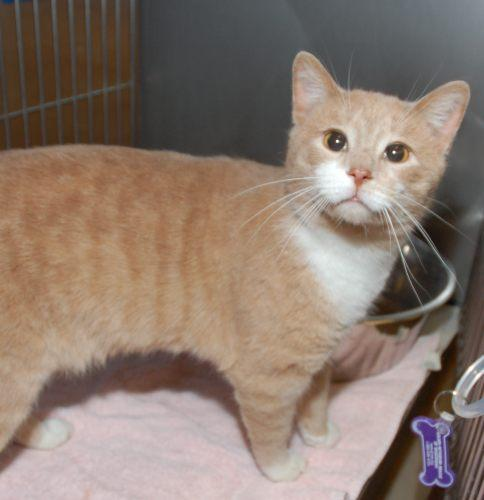

Sample of dog images


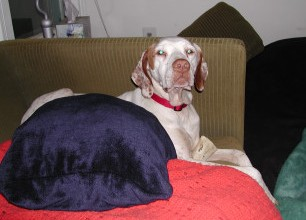

Sample of bird images


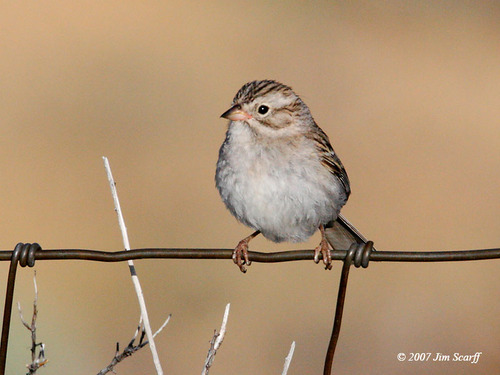

In [12]:
from IPython.display import Image, display

print("Sample of cat images")
display(Image(filename=f"{os.path.join(base_cats_dir, os.listdir(base_cats_dir)[0])}"))

print("Sample of dog images")
display(Image(filename=f"{os.path.join(base_dogs_dir, os.listdir(base_dogs_dir)[0])}"))

print("Sample of bird images")
display(Image(filename=f"{os.path.join(base_birds_dir, os.listdir(base_birds_dir)[0])}"))

### Train /  Evaluate Split

In [13]:
train_eval_dirs = ["train/cats", "train/dogs", "train/birds",
                   "eval/cats", "eval/dogs", "eval/birds"]

for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, dir)):
    os.makedirs(os.path.join(base_dir, dir))

In [14]:
def move_to_destination(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)

In [15]:
move_to_destination(base_cats_dir, os.path.join(base_dir, 'train/cats'), 0.7)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'train/dogs'), 0.7)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'train/birds'), 0.7)

# move remainder into evaluation folder
move_to_destination(base_cats_dir, os.path.join(base_dir, 'eval/cats'), 1)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'eval/dogs'), 1)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'eval/birds'), 1)

In [16]:
!find /tmp/data -size 0 -exec rm {} +
!find /tmp/data -type f ! -name "*.jpg" -exec rm {} +

In [18]:
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/birds')))} images of birds for training")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 8749 images of dogs for training
There are 8251 images of birds for training
There are 3749 images of cats for evaluation
There are 3750 images of dogs for evaluation
There are 3537 images of birds for evaluation


### Create Imbalanced Dataset 

In [20]:
for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, "imbalanced/"+dir)):
    os.makedirs(os.path.join(base_dir, 'imbalanced/'+dir))

In [21]:
def copy_with_limit(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.copy(os.path.join(origin, image_name), destination)

In [24]:
copy_with_limit(os.path.join(base_dir, "train/cats"), os.path.join(base_dir, 'imbalanced/train/cats'), 1)
copy_with_limit(os.path.join(base_dir, "train/dogs"), os.path.join(base_dir, 'imbalanced/train/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, "train/birds"), os.path.join(base_dir, 'imbalanced/train/birds'), 0.1)

copy_with_limit(os.path.join(base_dir, "eval/cats"), os.path.join(base_dir, 'imbalanced/eval/cats'), 1)
copy_with_limit(os.path.join(base_dir, "eval/dogs"), os.path.join(base_dir, 'imbalanced/eval/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, "eval/birds"), os.path.join(base_dir, 'imbalanced/eval/birds'), 0.1)

print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/birds')))} images of birds for training")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 1749 images of dogs for training
There are 825 images of birds for training
There are 3749 images of cats for evaluation
There are 750 images of dogs for evaluation
There are 353 images of birds for evaluation


### Selecting a model

In [26]:
from tensorflow.keras import layers, models, optimizers

def create_model():
  # simple CNN structure
  model = models.Sequential([
      layers.Conv2D(32, (3,3), activation="relu", input_shape=(150, 150, 3)),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3, 3), activation="relu"),
      layers.MaxPooling2D((2,2)), 
      layers.Conv2D(64, (3, 3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(128, (3, 3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(512, activation="relu"),
      layers.Dense(3, activation="softmax")
  ])

  # compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer = optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
      )
  
  return model

In [28]:
imbalanced_model = create_model()

print(imbalanced_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 64)      

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/tmp/data/imbalanced/train",
    target_size=(150,150),
    batch_size=32,
    class_mode="binary"
)

validation_generator = test_datagen.flow_from_directory(
    "/tmp/data/imbalanced/eval",
    target_size=(150,150),
    batch_size=32,
    class_mode="binary"
)

Found 11324 images belonging to 3 classes.
Found 4852 images belonging to 3 classes.


In [30]:
print(f"labels for each class in the train generator are {train_generator.class_indices}")
print(f"labels for each class in the validation generator are {validation_generator.class_indices}")

labels for each class in the train generator are {'birds': 0, 'cats': 1, 'dogs': 2}
labels for each class in the validation generator are {'birds': 0, 'cats': 1, 'dogs': 2}


### Train a CNN with class imbalanced data

In [31]:
# load the pretrained models on their histories

imbalanced_history = pd.read_csv("/content/history-imbalanced/history-imbalanced.csv")
imbalanced_model = tf.keras.models.load_model("model-imbalanced")

In [ ]:
# run only if you want to train model yourself 20-30 minutes with GPU 

#imbalanced_history = imabalanced_model.fit(
    #train_generator,
    #steps_per_epoch = 100,
    #epochs = 50,
    #valudation_data = validation_generator,
    #validation_steps = 80
#)

In [32]:
def get_training_metrics(history):
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history

  acc = history["sparse_categorical_accuracy"]
  val_acc = history["val_sparse_categorical_accuracy"]

  loss = history["loss"]
  val_loss = history["val_loss"]

  return acc, val_acc, loss, val_loss

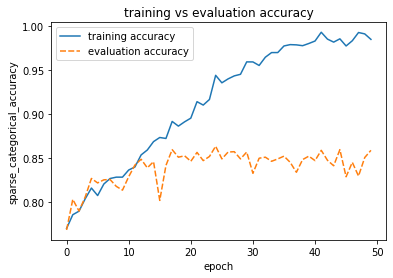

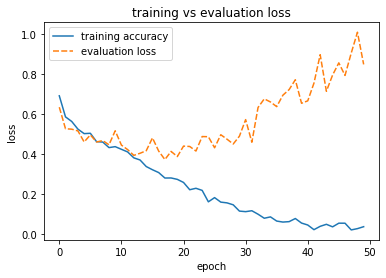

In [33]:
def plot_train_eval(history):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title("training vs evaluation accuracy")
  acc_plot.set_xlabel("epoch")
  acc_plot.set_ylabel("sparse_categorical_accuracy")
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training accuracy":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title("training vs evaluation loss")
  loss_plot.set_xlabel("epoch")
  loss_plot.set_ylabel("loss")
  plt.show()

plot_train_eval(imbalanced_history)

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [37]:
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/imbalanced/eval',
    target_size=(150,150),
    batch_size=32,
    class_mode = "binary",
    shuffle=False
)

Found 4852 images belonging to 3 classes.


In [38]:
y_true = val_gen_no_shuffle.classes

predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

print(f"Acc. Score: {accuracy_score(y_true, y_pred_imbalanced)}")

print(f"Balanced Acc. Score: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")

152/152 [==============================] - 69s 445ms/step
Acc. Score: 0.855111294311624
Balanced Acc. Score: 0.7417486453422518


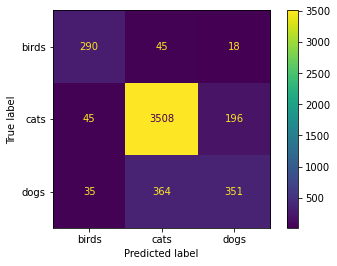

In [39]:
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=["birds", "cats", "dogs"]).plot(values_format="d")

In [40]:
misclassified_birds = (imbalanced_cm[1,0] + imbalanced_cm[2,0])/np.sum(imbalanced_cm, axis=0)[0]
misclassified_cats = (imbalanced_cm[0,1] + imbalanced_cm[2,1])/np.sum(imbalanced_cm, axis=0)[1]
misclassified_dogs = (imbalanced_cm[0,2] + imbalanced_cm[1,2])/np.sum(imbalanced_cm, axis=0)[2]

print(f"Proportion of misclassified birds {misclassified_birds*100:.2f}")
print(f"Proportion of misclassified cats {misclassified_cats*100:.2f}")
print(f"Proportion of misclassified dogs {misclassified_dogs*100:.2f}")

Proportion of misclassified birds 21.62
Proportion of misclassified cats 10.44
Proportion of misclassified dogs 37.88


In [43]:
all_cats = np.ones(y_true.shape)

print(f"Acc.Score: {accuracy_score(y_true, all_cats)}")

print(f"Balanced Acc.Score: {balanced_accuracy_score(y_true, all_cats)}")

Acc.Score: 0.7726710634789777
Balanced Acc.Score: 0.3333333333333333


In [44]:
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150,150),
    batch_size=32,
    class_mode = "binary",
    shuffle=False
)

y_true = val_gen_no_shuffle.classes

predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)

Found 11036 images belonging to 3 classes.
310/345 [=========================>....] - ETA: 16s

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

345/345 [==============================] - 159s 460ms/step


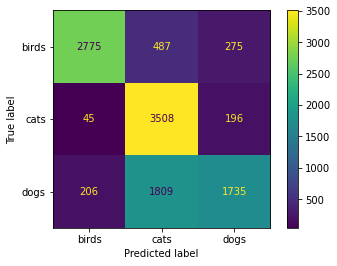

In [45]:
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

### Train with the complete dataset

In [46]:
balanced_model = create_model()

In [47]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [48]:
train_generator = train_datagen.flow_from_directory(
    "/tmp/data/train",
    target_size=(150,150),
    batch_size=32,
    class_mode = "binary"
)

test_generator = test_datagen.flow_from_directory(
    "/tmp/data/eval",
    target_size=(150,150),
    batch_size=32,
    class_mode = "binary"
)

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


In [49]:
balanced_history = pd.read_csv("history-balanced/history-balanced.csv")
balanced_model = tf.keras.models.load_model("model-balanced")

In [50]:
val_gen_no_shuffle = test_datagen.flow_from_directory(
    "/tmp/data/eval",
    target_size=(150,150),
    batch_size=32,
    class_mode = "binary",
    shuffle=False
)

Found 11036 images belonging to 3 classes.


In [51]:
y_true = val_gen_no_shuffle.classes

predictions_balanced = balanced_model.predict(val_gen_no_shuffle)

y_pred_balanced = np.argmax(predictions_balanced, axis=1)

print(f"Acc. Score: {accuracy_score(y_true, y_pred_balanced)}")
print(f"Balanced Acc. Score: {balanced_accuracy_score(y_true, y_pred_balanced)}")

311/345 [==========================>...] - ETA: 15s

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

345/345 [==============================] - 154s 445ms/step
Acc. Score: 0.8636281261326567
Balanced Acc. Score: 0.8647221799730266


In [52]:
balanced_cm = confusion_matrix(y_true, y_pred_balanced)

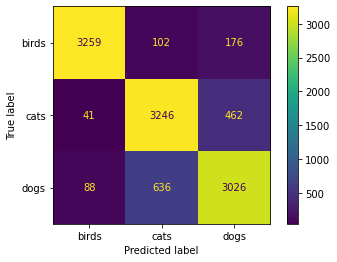

In [53]:
ConfusionMatrixDisplay(balanced_cm, display_labels=["birds", "cats", "dogs"]).plot(values_format="d")

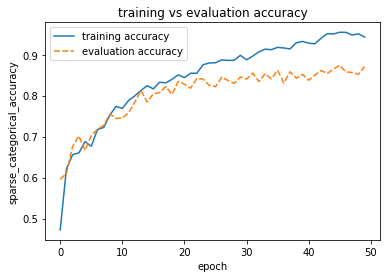

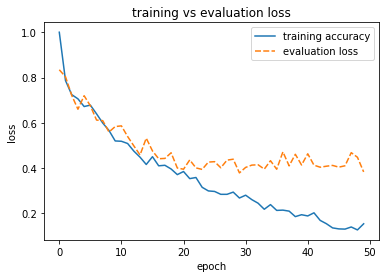

In [54]:
plot_train_eval(balanced_history)

### Training with Augmented Data

In [55]:
augumented_model = create_model()

In [56]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50, 
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/tmp/data/train",
    target_size=(150,150),
    batch_size=32,
    class_mode = "binary"
)

validation_generator = test_datagen.flow_from_directory(
    "/tmp/data/eval",
    target_size=(150,150),
    batch_size=32,
    class_mode = "binary"
)

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


Transformation Number: 0


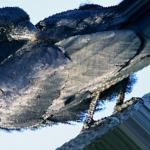

Transformation Number: 1


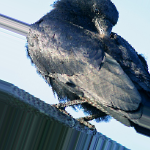

Transformation Number: 2


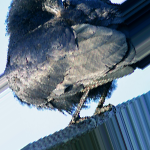

Transformation Number: 3


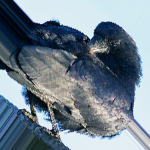

In [60]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img

def display_transformations(gen):
  train_birds_dir = "/tmp/data/train/birds"
  random_index = random.randint(0, len(os.listdir(train_birds_dir)))
  sample_image = load_img(f"{os.path.join(train_birds_dir, os.listdir(train_birds_dir)[random_index])}",
                           target_size=(150,150))
  sample_array = img_to_array(sample_image)
  sample_array = sample_array[None, :]

  for iteration, array in zip(range(4), gen.flow(sample_array, batch_size=1)):
    array = np.squeeze(array)
    img = array_to_img(array)
    print(f"Transformation Number: {iteration}")
    display(img)

sample_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50, 
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

display_transformations(sample_gen)

Transformation Number: 0


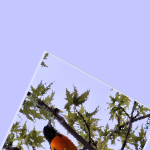

Transformation Number: 1


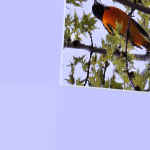

Transformation Number: 2


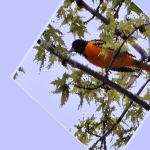

Transformation Number: 3


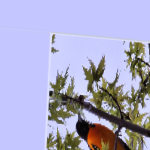

In [61]:
sample_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90, 
    width_shift_range=0.50,
    height_shift_range=0.50,
    shear_range=0.7,
    zoom_range=0.3,
    horizontal_flip=True
)

display_transformations(sample_gen)

In [62]:
augmented_history = pd.read_csv("history-augmented/history-augmented.csv")
augmented_model = tf.keras.models.load_model("model-augmented")

In [ ]:
# augmented_history = augmented_model.fit(
    #train_generator,
    #steps_per_epoch = 100, 
    #epochs = 80,
    #validation_data = validation_generator, 
    #validation_steps=80
#)

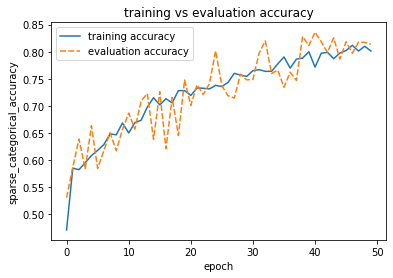

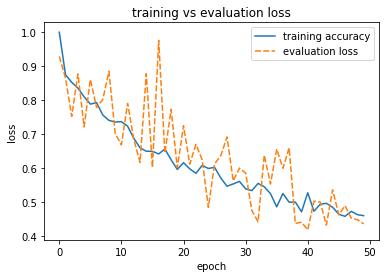

In [63]:
plot_train_eval(augmented_history)